# 1. Task Description
给定诸多属性，预测某人收入是否超过50000美元。

**Notes**

使用one-hot vector 处理离散型属性，具体而言，某些属性取离散值，如何进行预处理，这一直是我的疑问，这里算是一个方法。举例：
属性education，可能包含n个离散值High scholl graduate、Master degree、Children……如何数据化？
one-hot vector的方法是将其变为两n个属性，每个属性只取0，1两种值。

**WHY**

我过往的想法是直接给n个值编号，利用编号代替属性取值，但仔细想想这样是不好的。相当于给某个属性下的取值赋予了不同权重，但其实这些取值是对等的，而且，例如理发师编号为10，而CEO编号为11，loss function只会感知到大小，无法感知离散取值不同。所以这种奇怪的one-hot vector才是正确的做法。



# 2. Processing

1. 读取数据
2. 标准化
3. 切分数据

In [1]:
import numpy as np

np.random.seed(0)

X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

def normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X, X_mean, X_std = normalize(X, train = True)
X_test, _, _= normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = train_dev_split(X, Y, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


# 2. Model - Logistic Regression

## 2.1 Logistic Regression

$$Z=X\cdot W + B=\sum_iw_i \cdot x_i + b \\ Y=\sigma(Z)=\frac{1}{1+e^{-Z}}$$

**Cross Entropy**

$$L = -\frac{1}{N}\sum_{n=1}^{N}\hat{y}_n \log y_n + \left( 1 - \hat{y}_n \right) \log \left( 1 -  y_n \right) + \frac{\lambda}{2N} \sum_i w_i^{2}$$

**Gradient**

$$W = W - \eta \left[ \frac{1}{N} \left( Y - \hat{Y} \right) ^ \mathrm{T} X + \frac{\lambda}{N} W \right]= w_i -\eta \left[ \frac{1}{N}\sum_n\left( y_n -  \hat{y}_n\right) x_{ni} + \frac{\lambda}{N} w_i \right]  \\ B = B - \frac{\eta}{N}\left( Y - \hat{Y} \right) $$ 

注：n 指sample数量，i 指 W 的维度。

实现中把loss function中的1/N去掉。

## 2.2 implementation

In [2]:
def shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])


def sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))


def f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return sigmoid(np.matmul(X, w) + b)


def predict(X, w, b):
    # This function returns a truth value prediction for each row of X
    # by rounding the result of logistic regression function.
    return np.round(f(X, w, b)).astype(np.int)


def accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc


def cross_entropy_loss(y_pred, Y_label,w=None,lambda_ = 0):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    N = y_pred.shape[0]
    cross_entropy = -(np.dot(Y_label, np.log(y_pred)) \
            + np.dot((1 - Y_label), np.log(1 - y_pred)))/N
    if lambda_:
        cross_entropy += lambda_/2/N * np.dot(w,w)
    return cross_entropy


def gradient(X, Y_label, w, b,lambda_ = 0):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = f(X, w, b)
    pred_error = y_pred - Y_label 
    N = Y_label.shape[0]
    w_grad = (np.sum(pred_error * X.T, 1) + lambda_ * w)/N
    b_grad = np.sum(pred_error)/N
    return w_grad, b_grad

In [3]:

learning_rate = 0.01
lambda_ = 0
epoch = 125
batch_size = 8



w = np.zeros([X_train.shape[1],])
b = np.zeros([1, ])
iter = np.ceil(X_train.shape[0]/batch_size).astype(int)
step = 1
train_loss =[]
val_loss = []
train_acc = []
val_acc = []

for e in range(epoch):
    X_train, Y_train = shuffle(X_train, Y_train)
    for i in range(iter):
        BX = X_train[i*batch_size:(i+1)*batch_size]
        BY = Y_train[i*batch_size:(i+1)*batch_size]
        grad_w, grad_b = gradient(BX, BY, w, b,lambda_ = lambda_)
    
        w = w - learning_rate/np.sqrt(step)*grad_w
        b = b - learning_rate/np.sqrt(step)*grad_b

        step += 1
    Y_pred = f(X_train, w,b)
    Y_dev_pred = f(X_dev,w,b)
    train_loss.append(cross_entropy_loss(Y_pred,Y_train,w,lambda_))
    val_loss.append(cross_entropy_loss(Y_dev_pred,Y_dev,w,lambda_))
    Y_pred = np.round(Y_pred)
    Y_dev_pred = np.round(Y_dev_pred)
    train_acc.append(accuracy(Y_pred,Y_train))
    val_acc.append(accuracy(Y_dev_pred,Y_dev))

    print("t_loss: {:.4}, v_loss: {:.4},t_acc: {:.4},v_acc: {:.4}".format(train_loss[-1],val_loss[-1],train_acc[-1],val_acc[-1]))

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(val_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(val_acc[-1]))



t_loss: 0.4655, v_loss: 0.4695,t_acc: 0.823,v_acc: 0.8229
t_loss: 0.4311, v_loss: 0.4365,t_acc: 0.8405,v_acc: 0.8339
t_loss: 0.4111, v_loss: 0.4174,t_acc: 0.8489,v_acc: 0.8411
t_loss: 0.3972, v_loss: 0.4041,t_acc: 0.8539,v_acc: 0.8454
t_loss: 0.3867, v_loss: 0.3941,t_acc: 0.8577,v_acc: 0.8472
t_loss: 0.3784, v_loss: 0.3861,t_acc: 0.8601,v_acc: 0.8505
t_loss: 0.3715, v_loss: 0.3795,t_acc: 0.8622,v_acc: 0.8513
t_loss: 0.3657, v_loss: 0.374,t_acc: 0.8639,v_acc: 0.8544
t_loss: 0.3607, v_loss: 0.3692,t_acc: 0.8655,v_acc: 0.8553
t_loss: 0.3564, v_loss: 0.3651,t_acc: 0.8665,v_acc: 0.8575
t_loss: 0.3525, v_loss: 0.3614,t_acc: 0.8674,v_acc: 0.8585
t_loss: 0.3491, v_loss: 0.3581,t_acc: 0.8684,v_acc: 0.8607
t_loss: 0.346, v_loss: 0.3552,t_acc: 0.8695,v_acc: 0.8609
t_loss: 0.3432, v_loss: 0.3526,t_acc: 0.8699,v_acc: 0.8612
t_loss: 0.3407, v_loss: 0.3501,t_acc: 0.8706,v_acc: 0.8616
t_loss: 0.3384, v_loss: 0.3479,t_acc: 0.871,v_acc: 0.8616
t_loss: 0.3362, v_loss: 0.3459,t_acc: 0.8716,v_acc: 0.8614
t

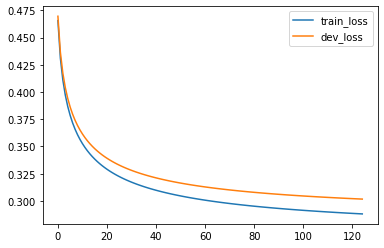

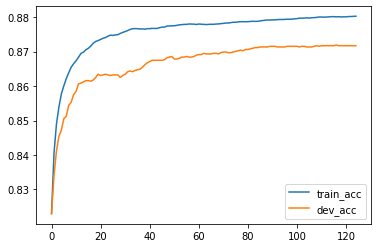

In [4]:

# plot loss
from matplotlib import pyplot as plt
plt.plot(train_loss, label = 'train_loss')
plt.plot(val_loss,label = 'dev_loss')
plt.legend()
plt.show()
plt.plot(train_acc,label = 'train_acc')
plt.plot(val_acc,label = 'dev_acc')
plt.legend()
plt.show()

In [5]:
np.save('w.npy',w)
# # Predict testing labels
predictions = predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

## 2.3 Tuning Analyze

从一开始模型loss波动非常剧烈到后期逐渐稳定下来，调参经验如下。

- learning rate不要设置太大，损失函数设计也不要让梯度太大，否则会导致波动剧烈，无法收敛，梯度爆炸等问题。
- batch_size，小批量梯度下降，这个参数影响随机梯度下降，设置得小，每次会选择很局部的梯度，模型波动会更强更不稳定，但是由于size小，跑完一次数据的iter就多，所以收敛要较快，而且我们也可以期望更大的随机性能有更大的可能让我们找到全局最优解。设置得大的话，可以考虑最大是整个数据集，即关闭小批量梯度下降，所以设置得越大，每次梯度越全局化，整体下降也更加稳定，但是，相应的size大，iter就小，所以看起来收敛会慢一点，可以适当提高epoch以得到相同的效果。
- loss function实际上在上述实验中，对训练并无影响，为了方便可视化，应该设置合适的大小，很多看起来奇怪的结果，其实是可视化没做好。

多次实验后，我的基本结论是：

上述结果，已经接近瓶颈了，换句话说，逻辑回归模型中，510维度特征的基本就是这个performance，如果要更进一步，应该考虑feature selection。

## 2.4 Feature Selection

这是权重的分布。

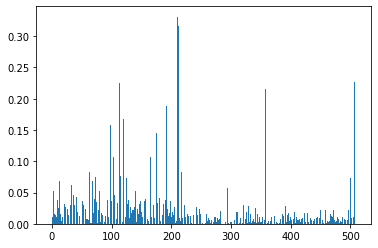

In [29]:
# show weight distribution
plt.bar(range(len(w)),abs(w))
plt.show()

In [30]:
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)[1:]
print("{:3}, {:50}, {}".format('id','features', 'weight'))
for i in ind[0:10]:
    print("{:3}, {:40}, {}".format(i,features[i].strip(), w[i]))

id , features                                          , weight
210, capital gains                           , 0.3312179777553165
212, dividends from stocks                   , 0.31609651785976073
507, weeks worked in year                    , 0.2274132217270788
113, Masters degree(MA MS MEng MEd MSW MBA)  , 0.22589457224499335
358, num persons worked for employer         , 0.214848453806637
  0, age                                     , 0.21019529971494316
191, Male                                    , 0.18821640011729027
192, Female                                  , -0.18821640011729018
120, Doctorate degree(PhD EdD)               , 0.16728958419703682
211, capital losses                          , 0.16534364759523143


可以看到上述的前十的影响因素，资产相关，工作时间，学位相关，性别……发现在这种one-hot编码下，我们可以直接分割属性。

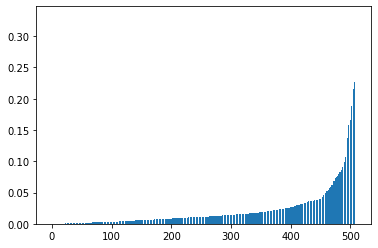

In [31]:
# show weight distribution(sorted)
plt.bar(range(len(w)),np.sort(abs(w)))
plt.show()

可以看排序版的权重分布，二八定律在这里应该是适用的。可以看到300之前的权重基本就低于0.025.

**选取前200个features**

t_loss: 0.2743, v_loss: 0.2885,t_acc: 0.8824,v_acc: 0.8719
t_loss: 0.271, v_loss: 0.285,t_acc: 0.883,v_acc: 0.8763
t_loss: 0.2698, v_loss: 0.2835,t_acc: 0.8834,v_acc: 0.8785
t_loss: 0.2687, v_loss: 0.2827,t_acc: 0.8838,v_acc: 0.8774
t_loss: 0.2682, v_loss: 0.2824,t_acc: 0.884,v_acc: 0.8785
t_loss: 0.2679, v_loss: 0.2822,t_acc: 0.8843,v_acc: 0.8784
t_loss: 0.2677, v_loss: 0.2821,t_acc: 0.8842,v_acc: 0.8771
t_loss: 0.2674, v_loss: 0.2819,t_acc: 0.8842,v_acc: 0.8776
t_loss: 0.2672, v_loss: 0.2817,t_acc: 0.8843,v_acc: 0.878
t_loss: 0.2671, v_loss: 0.2816,t_acc: 0.8842,v_acc: 0.8769
Training loss: 0.26709118801135306
Development loss: 0.28161317880417125
Training accuracy: 0.8841900471021913
Development accuracy: 0.876889052709178


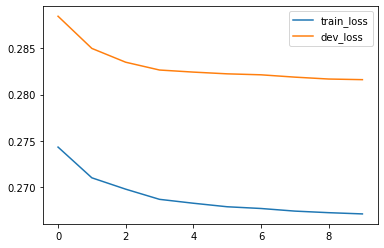

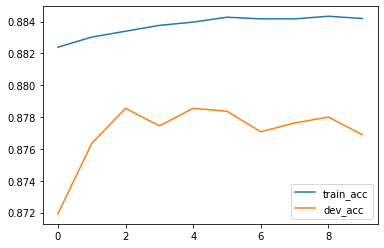

In [7]:
w = np.load('./w.npy')
ind = np.argsort(np.abs(w))[::-1]
sind = np.sort(ind[:200])
X_train_s = X_train[:,sind]
X_dev_s = X_dev[:,sind]

learning_rate = 1
lambda_ = 0
epoch = 10
batch_size = 128
w_s = np.zeros([X_train_s.shape[1],])
b = np.zeros([1, ])
iter = np.ceil(X_train.shape[0]/batch_size).astype(int)
step = 1
train_loss =[]
val_loss = []
train_acc = []
val_acc = []

for e in range(epoch):
    X_train_s, Y_train = shuffle(X_train_s, Y_train)
    for i in range(iter):
        BX = X_train_s[i*batch_size:(i+1)*batch_size]
        BY = Y_train[i*batch_size:(i+1)*batch_size]
        grad_w, grad_b = gradient(BX, BY, w_s, b,lambda_ = lambda_)
    
        w_s = w_s - learning_rate/np.sqrt(step)*grad_w
        b = b - learning_rate/np.sqrt(step)*grad_b

        step += 1
    Y_pred = f(X_train_s, w_s,b)
    Y_dev_pred = f(X_dev_s,w_s,b)
    train_loss.append(cross_entropy_loss(Y_pred,Y_train,w_s,lambda_))
    val_loss.append(cross_entropy_loss(Y_dev_pred,Y_dev,w_s,lambda_))
    Y_pred = np.round(Y_pred)
    Y_dev_pred = np.round(Y_dev_pred)
    train_acc.append(accuracy(Y_pred,Y_train))
    val_acc.append(accuracy(Y_dev_pred,Y_dev))

    print("t_loss: {:.4}, v_loss: {:.4},t_acc: {:.4},v_acc: {:.4}".format(train_loss[-1],val_loss[-1],train_acc[-1],val_acc[-1]))

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(val_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(val_acc[-1]))


# plot loss
from matplotlib import pyplot as plt
plt.plot(train_loss, label = 'train_loss')
plt.plot(val_loss,label = 'dev_loss')
plt.legend()
plt.show()
plt.plot(train_acc,label = 'train_acc')
plt.plot(val_acc,label = 'dev_acc')
plt.legend()
plt.show()

按上述设置，确实有所提高，但是kaggle上面测试，又只有0.87763，连simple baseline也没过。。最好的成绩是0.88936，不知道那些破90的做了什么，估计改变了模型。而且我最后又试了以下以最好成绩的配置，只改变features数量，结果表明，features selection在val set上有用，但在kaggle的test set上没有用，或者我方式没做对。

# 3. Model - Probabilistic genereative model

## 3.1 Math

$$P\left(C_{1} | x\right)=\frac{P\left(x | C_{1}\right) P\left(C_{1}\right)}{P\left(x | C_{1}\right) P\left(C_{1}\right)+P\left(x | C_{2}\right) P\left(C_{2}\right)}$$

已知x，求它属于$C_1$的概率。其中$P(C_i)$只需要统计train set中的频率，以此来替代整体概率。

然后是$P(x|C_i)$，已知分类情况下，x属于该分类的概率。模型假设某分类$C_i$服从正态分布，以此来求这个概率。

$$f_{\mu, \Sigma}(x)=\frac{1}{(2 \pi)^{D / 2}} \frac{1}{|\Sigma|^{1 / 2}} \exp \left\{-\frac{1}{2}(x-\mu)^{T} \Sigma^{-1}(x-\mu)\right\}$$

上述为正态分布公式，正态分布，则重点是两个参数的求取——遍历所有情况，寻求最大置信度，置信度定义如下。

$$L(\mu, \Sigma)=f_{\mu, \Sigma}\left(x^{1}\right) f_{\mu, \Sigma}\left(x^{2}\right) f_{\mu, \Sigma}\left(x^{3}\right) \dots \dots f_{\mu, \Sigma}\left(x^{n}\right)$$

在二分类的情况下，上述公式可以做如下变形。

$$P\left(C_{1} | x\right)=\frac{1}{1+\exp (-z)}$$

$$z=\ln \frac{P\left(x | C_{1}\right) P\left(C_{1}\right)}{P\left(x | C_{2}\right) P\left(C_{2}\right)}$$

所以，上述很多公式其实都是用不到的，对于z我们做如下推导。

$$z=\left(\mu^{1}-\mu^{2}\right)^{T} \Sigma^{-1} x-\frac{1}{2}\left(\mu^{1}\right)^{T} \Sigma^{-1} \mu^{1}+\frac{1}{2}\left(\mu^{2}\right)^{T} \Sigma^{-1} \mu^{2}+\ln \frac{N_{1}}{N_{2}}$$

然后我们发现逻辑回归和概率模型本质上是一样的。

$$Z=X \cdot W+B  \\ Y =\sigma(Z)=\frac{1}{1+e^{-Z}}$$

然后，剩下的问题就是$Σ$和$ \mu$怎么求。

$$\mu^{*}=\frac{1}{N} \sum_{n=1}^{N} x^{n} \\ \Sigma^{*}=\frac{1}{N} \sum_{n=1}^{N}\left(x^{n}-\mu^{*}\right)\left(x^{n}-\mu^{*}\right)^{T}$$

注意，上述的 x 仅仅只一个维度的特征。而不是输入的X矩阵。那么，多维度的特征应该怎么办呢？

模型再次假设所有维度是相关的，它们共享一个co-variance矩阵，即$\sum$矩阵，然后各自拥有独立的mean，即$\mu_i$。前者求法如下，后者求法和上面是一样的。

$$\Sigma=\frac{79}{140} \Sigma^{1}+\frac{61}{140} \Sigma^{2}$$

上面使用了一个具体的例子来展示加权平均的公式。

## 3.2 Implementation

In [8]:
import numpy as np

X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

np.random.seed(0)
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

# Normalize training and testing data
X_train, X_mean, X_std = normalize(X_train, train = True)
X_test, _, _= normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

In [ ]:
# Compute in-class mean
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)  

# Compute in-class covariance
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

经典的使用svd分解求逆。

In [13]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# Compute accuracy on training set
Y_train_pred = 1 - predict(X_train, w, b)
print('Training accuracy: {}'.format(accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.8719772928339723


In [15]:
# Predict testing labels
predictions = 1 - predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Retail trade 9.948974609375
 34 -7.5440673828125
 37 -6.945068359375
 Other service -6.31884765625
 Different state in Midwest -5.08984375
 Manufacturing-nondurable goods 4.40625
 31 -4.37109375
 Forestry and fisheries 3.806640625
 29 -3.78515625
 Not identifiable -3.765625
